Importing Libraries:

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Reading datasets:

In [22]:
train1 = pd.read_csv('train_data/dataset1_train.csv')
test1 = pd.read_csv('test_data/dataset1_test.csv')

In [23]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    float64
 1   x2      100 non-null    float64
 2   label   100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [24]:
train1.sample(5)

,x1,x2,label
36,0.296417,0.856464,1
54,0.675461,0.224626,2
34,0.336164,0.635488,1
84,0.628470,0.367960,2
47,0.260789,0.553649,1


Finding the distribution:
We plot histograms while indicating each class with a different colour to see the distribution.

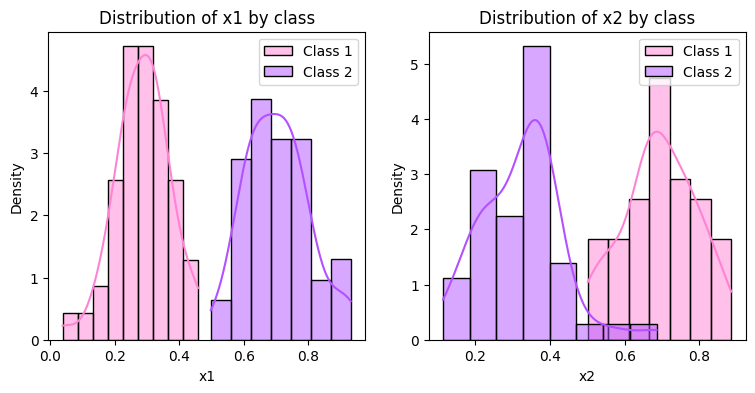

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.histplot(train1[train1["label"]==1]["x1"], kde=True, color="#FF83D4", ax=axes[0], label="Class 1", stat="density")
sns.histplot(train1[train1["label"]==2]["x1"], kde=True, color="#B350FF", ax=axes[0], label="Class 2", stat="density", alpha=0.5)
axes[0].set_title("Distribution of x1 by class")
axes[0].legend()

sns.histplot(train1[train1["label"]==1]["x2"], kde=True, color="#FF83D4", ax=axes[1], label="Class 1", stat="density")
sns.histplot(train1[train1["label"]==2]["x2"], kde=True, color="#B350FF", ax=axes[1], label="Class 2", stat="density", alpha=0.5)
axes[1].set_title("Distribution of x2 by class")
axes[1].legend()

plt.show()


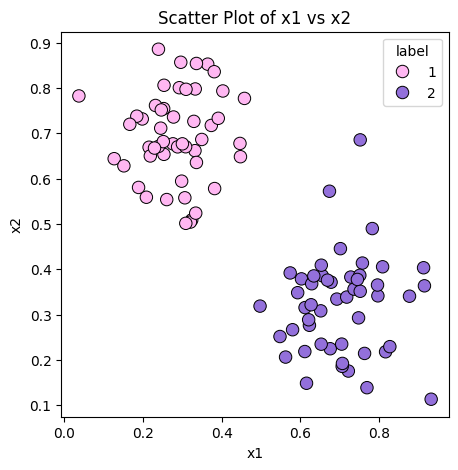

In [26]:
fig, axes = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=train1, x="x1", y="x2", hue="label", palette=["#FFB7F2", "#9370DB"], s=80, edgecolor="k")
plt.title("Scatter Plot of x1 vs x2")
plt.show()

It is apparent that there is a Gaussian Distribution, so we can use this for MLE.

Estimating class parameters:

In [27]:
# 1. µ1, µ2

mu1 = train1[train1["label"]==1][["x1","x2"]].mean().values
mu2 = train1[train1["label"]==2][["x1","x2"]].mean().values

print("μ1 =", mu1)
print("μ2 =", mu2)

μ1 = [0.28643244 0.69279826]
μ2 = [0.70281086 0.32278163]


In [28]:
# 2. Σ1, Σ2

X1 = train1[train1.label==1][["x1","x2"]].values
X2 = train1[train1.label==2][["x1","x2"]].values

sigma1 = ((X1 - mu1).T @ (X1 - mu1)) / len(X1)
sigma2 = ((X2 - mu2).T @ (X2 - mu2)) / len(X2)

print("Σ1 =\n", sigma1)
print("Σ2 =\n", sigma2)


Σ1 =
 [[0.00682389 0.00033128]
 [0.00033128 0.00948629]]
Σ2 =
 [[0.00929122 0.00050833]
 [0.00050833 0.0113118 ]]


In [29]:
n_total = len(train1)
n1 = (train1.label == 1).sum()
n2 = (train1.label == 2).sum()

c1 = n1 / n_total   # P(y=1)
c2 = n2 / n_total   # P(y=2)

print("c1 =", c1)
print("c2 =", c2)

c1 = 0.5
c2 = 0.5


In [30]:
def gaussian_pdf(x, mu, Sigma):
    d = len(mu)  # number of features (2 here)
    det = np.linalg.det(Sigma)
    inv = np.linalg.inv(Sigma)
    norm_const = 1.0 / (np.sqrt((2*np.pi)**d * det))
    diff = x - mu
    exponent = -0.5 * diff.T @ inv @ diff
    return norm_const * np.exp(exponent)

posteriors = []
X_test = test1[["x1","x2"]].values  # test features

for x in X_test:
    p1 = gaussian_pdf(x, mu1, sigma1) * c1
    p2 = gaussian_pdf(x, mu2, sigma2) * c2
    norm = p1 + p2
    post1 = p1 / norm
    post2 = p2 / norm
    posteriors.append([post1, post2])

posteriors = np.array(posteriors)


In [31]:
y_pred = np.argmax(posteriors, axis=1) + 1   # predictions
y_true = test1["label"].values              # true labels

accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 1.0


Plotting Predicted vs True Values:

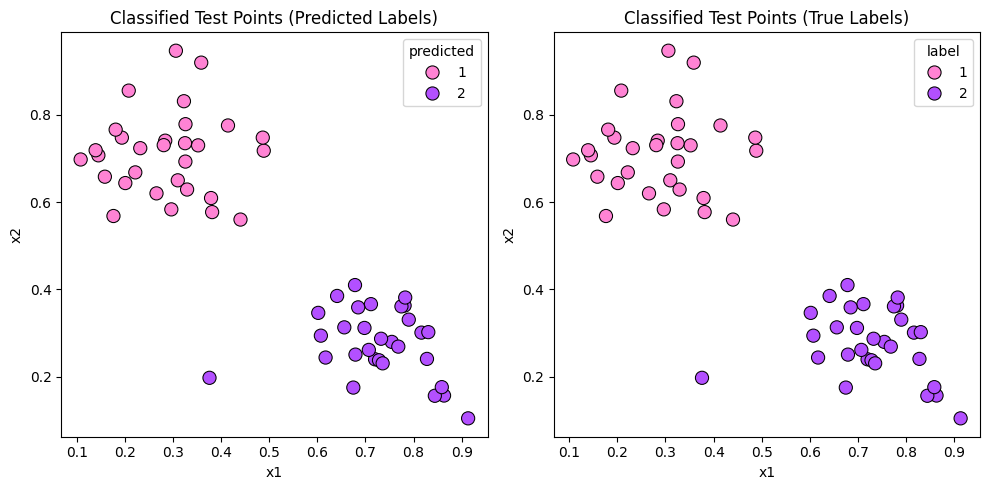

In [32]:
test1["predicted"] = y_pred

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(data=test1, x="x1", y="x2", hue="predicted", palette=["#FF83D4", "#B350FF"], s=90, edgecolor="k")
plt.title("Classified Test Points (Predicted Labels)")
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1,2,2)
sns.scatterplot(data=test1, x="x1", y="x2", hue="label", palette=["#FF83D4", "#B350FF"], s=90, edgecolor="k")
plt.title("Classified Test Points (True Labels)")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()

They are the exact same. Accuracy is 100%. Dataset 1 complete.

Now, we make a reusable function that includes all of the above steps for simplicity.

In [33]:
def bayes_gaussian_classifier(train, test, features=["x1","x2"], label_col="label"):
    # 1. Class Parameters (µ1, µ2)
    mu1 = train[train[label_col] == 1][features].mean().values
    mu2 = train[train[label_col] == 2][features].mean().values

    # 2. Covariance Matrices (Σ1, Σ2)
    X1 = train[train[label_col] == 1][features].values
    X2 = train[train[label_col] == 2][features].values

    sigma1 = ((X1 - mu1).T @ (X1 - mu1)) / len(X1)
    sigma2 = ((X2 - mu2).T @ (X2 - mu2)) / len(X2)

    # 3. Priors
    n_total = len(train)
    n1 = (train[label_col] == 1).sum()
    n2 = (train[label_col] == 2).sum()

    c1 = n1 / n_total
    c2 = n2 / n_total

    # Gaussian
    def gaussian_pdf(x, mu, Sigma):
        d = len(mu)
        det = np.linalg.det(Sigma)
        inv = np.linalg.inv(Sigma)
        norm_const = 1.0 / (np.sqrt((2*np.pi)**d * det))
        diff = x - mu
        exponent = -0.5 * diff.T @ inv @ diff
        return norm_const * np.exp(exponent)

    # 4. Posterior probabilities
    posteriors = []
    X_test = test[features].values

    for x in X_test:
        p1 = gaussian_pdf(x, mu1, sigma1) * c1
        p2 = gaussian_pdf(x, mu2, sigma2) * c2
        norm = p1 + p2
        post1 = p1 / norm
        post2 = p2 / norm
        posteriors.append([post1, post2])

    posteriors = np.array(posteriors)

    # 5. Predictions & Accuracy
    y_pred = np.argmax(posteriors, axis=1) + 1
    y_true = test[label_col].values
    accuracy = np.mean(y_pred == y_true)

    # Results
    print("μ1 =", mu1)
    print("μ2 =", mu2)
    print("Σ1 =\n", sigma1)
    print("Σ2 =\n", sigma2)
    print("c1 =", c1)
    print("c2 =", c2)
    print("Accuracy =", accuracy)

    return posteriors, y_pred, accuracy


Now we proceed to dataset 2.

Reading Datasets:

In [34]:
train2 = pd.read_csv('train_data/dataset2_train.csv')
test2 = pd.read_csv('test_data/dataset2_test.csv')

In [35]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    float64
 1   x2      100 non-null    float64
 2   label   100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [36]:
train2.sample(5)

,x1,x2,label
63,0.516223,0.477813,2
18,0.497382,0.459178,1
42,0.436351,0.588084,1
53,0.508561,0.447046,2
9,0.558397,0.420277,1


Finding the distribution:
Again, we plot histograms to find the distribution.

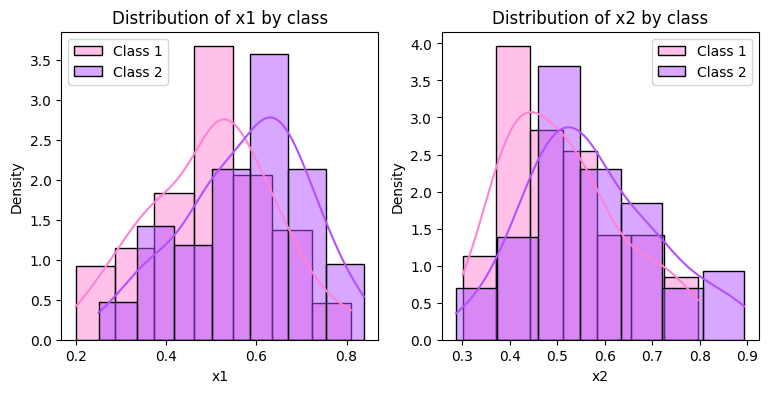

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.histplot(train2[train2["label"]==1]["x1"], kde=True, color="#FF83D4", ax=axes[0], label="Class 1", stat="density")
sns.histplot(train2[train2["label"]==2]["x1"], kde=True, color="#B350FF", ax=axes[0], label="Class 2", stat="density", alpha=0.5)
axes[0].set_title("Distribution of x1 by class")
axes[0].legend()

sns.histplot(train2[train2["label"]==1]["x2"], kde=True, color="#FF83D4", ax=axes[1], label="Class 1", stat="density")
sns.histplot(train2[train2["label"]==2]["x2"], kde=True, color="#B350FF", ax=axes[1], label="Class 2", stat="density", alpha=0.5)
axes[1].set_title("Distribution of x2 by class")
axes[1].legend()

plt.show()

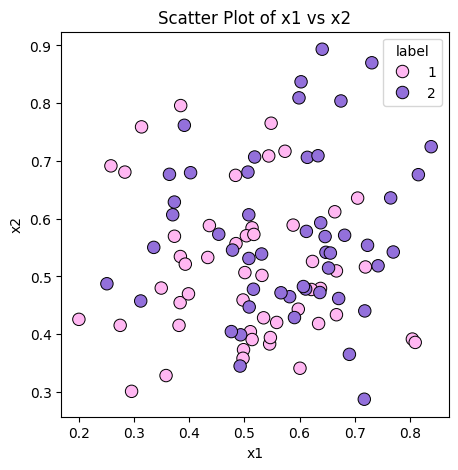

In [38]:
fig, axes = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=train2, x="x1", y="x2", hue="label", palette=["#FFB7F2", "#9370DB"], s=80, edgecolor="k")
plt.title("Scatter Plot of x1 vs x2")
plt.show()

The distribution is skewed, and the overlap between the features is expected to introduce classification errors.

Applying our function:

In [39]:
posteriors, y_pred, acc = bayes_gaussian_classifier(train2, test2)

μ1 = [0.50279938 0.50981493]
μ2 = [0.57722241 0.57290926]
Σ1 =
 [[ 0.01888129 -0.00203952]
 [-0.00203952  0.01479241]]
Σ2 =
 [[0.01805917 0.00163931]
 [0.00163931 0.01864453]]
c1 = 0.5
c2 = 0.5
Accuracy = 0.7333333333333333


Plotting Predicted vs True Values:

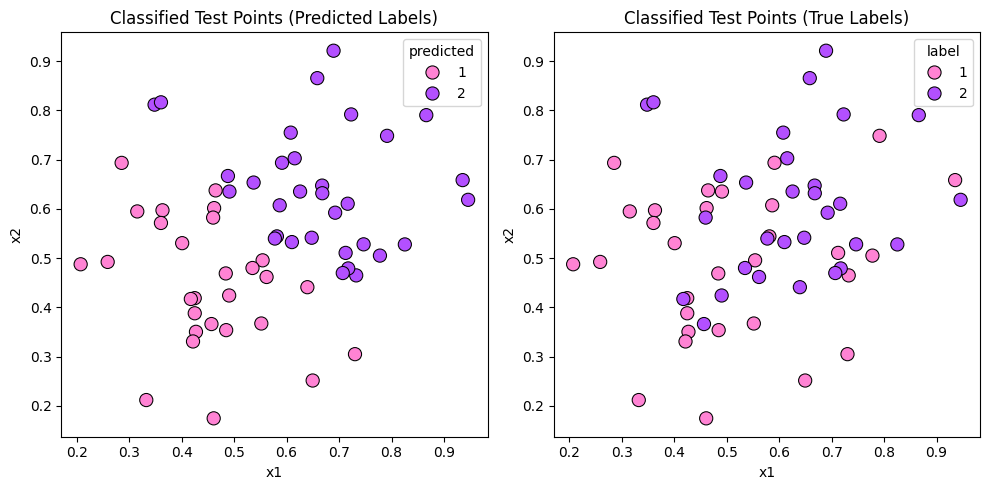

In [40]:
test2["predicted"] = y_pred

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(data=test2, x="x1", y="x2", hue="predicted", palette=["#FF83D4", "#B350FF"], s=90, edgecolor="k")
plt.title("Classified Test Points (Predicted Labels)")
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1,2,2)
sns.scatterplot(data=test2, x="x1", y="x2", hue="label", palette=["#FF83D4", "#B350FF"], s=90, edgecolor="k")
plt.title("Classified Test Points (True Labels)")
plt.xlabel("x1")
plt.ylabel("x2")

plt.tight_layout()
plt.show()

As anticipated from the distribution, classification errors arise due to overlapping regions and the non-Gaussian nature of the data. The accuracy is 73.3%